<a href="https://colab.research.google.com/github/ErfanNourian/CNN_image_classification/blob/main/DL_Exercise1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
import os
import PIL
import pathlib
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import re
import pandas as pd
import shutil
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from keras import backend as K
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import cv2
import zipfile
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
# Upload files
#uploaded = files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
zip_file_path = '/content/drive/MyDrive/brain_tumor_dataset.zip'
extract_to = 'extracted_file'
def extract_zip(zip_file_path, extract_to):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
extract_zip(zip_file_path, extract_to)

In [96]:
data_dir = pathlib.Path('/content/extracted_file/brain_tumor_dataset').with_suffix('')
images = (list(data_dir.glob('*/*')))
random.shuffle(images)



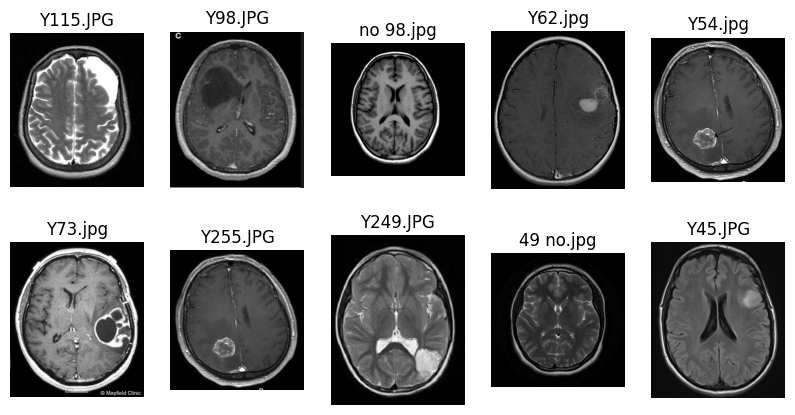

In [97]:
# Demonstration
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(PIL.Image.open(images[i]).convert('RGB'))
    plt.title(str(images[i]).split("/")[-1])
    plt.axis('off')


In [98]:
dimensions = []
for image in images:
  with PIL.Image.open(image) as img:
    dimensions.append(list(img.size))


In [99]:
dimensions = np.array(dimensions)
dimensions.shape

(253, 2)

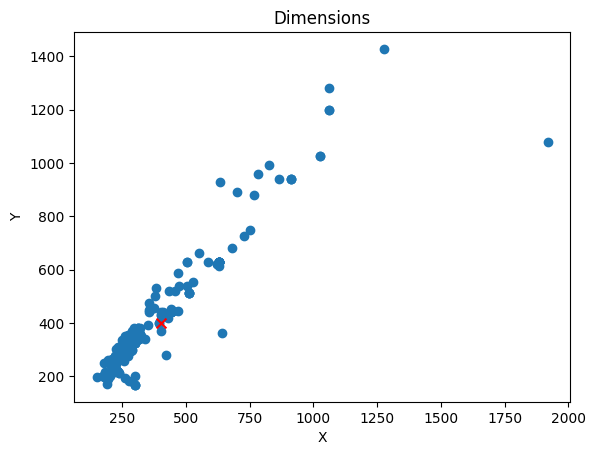

In [100]:
# Scatter dimentions
x = dimensions[:, 0]
y = dimensions[:, 1]
target_width = 400
target_height = 400
plt.scatter(x, y)
plt.scatter(target_width, target_height, color='red', marker='x', s=50, label='Specific Point')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Dimensions')
plt.show()

In [101]:
def add_padding(images):
  padded_img, labels = [], []

  for image in images:
    with PIL.Image.open(image) as img:
      img_width, img_height = img.size

      width_ratio = target_width / img_width
      height_ratio = target_height / img_height

      ratio = min(width_ratio, height_ratio)

      new_width = int(img_width * ratio)
      new_height = int(img_height * ratio)

      resized_img = img.resize((new_width, new_height), PIL.Image.NEAREST)
      letterbox_img = PIL.Image.new('L', (target_width, target_height))

      left_offset = (target_width - new_width) // 2
      top_offset = (target_height - new_height) // 2

      letterbox_img.paste(resized_img, (left_offset, top_offset))
      padded_img.append(((letterbox_img.convert('L'))))

      if len(re.findall(".*y.*|.*Y.*", str(image).split("/")[-1])) != 0:
        labels.append(1) #YES
      else:
        labels.append(0) #NO
  padded_img = np.reshape(padded_img, (-1, 400, 400))
  labels = np.array(labels)
  return padded_img, labels

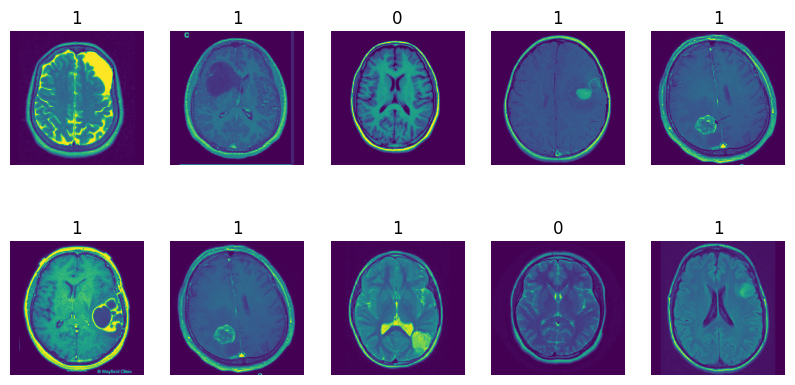

In [102]:
padded_img, labels = add_padding(images)
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(padded_img[i])
    plt.title(labels[i])
    plt.axis('off')

In [103]:
X_train, X_test, y_train, y_test = train_test_split(padded_img, labels, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [1]:
print('X_train: \n',X_train)
print('y_train: \n',y_train)

NameError: name 'X_train' is not defined

In [ ]:
def res_block(x, filters):
  fx = layers.Conv2D(filters, (3,3), padding='same', strides=(1,1), activation='relu')(x)
  fx = layers.BatchNormalization()(fx)
  fx = layers.Conv2D(filters, (3,3), padding='same', strides=(1,1))(fx)
  #fx = layers.BatchNormalization()(fx)
  out = layers.Add([x, fx])
  out = layers.Relu()(out)
  out = layers.BatchNormalization()(out)
  return out

In [107]:
x = layers.InputLayer(input_shape=(target_height, target_width, 1), batch_size=10) #input_shape = (height, width, channel)
y = layers.DepthwiseConv2D(3, strides=(1,1), padding='valid', depth_multiplier=1)(x)
y = layers.Conv2D(8, (3,3), padding='same')(y)
y = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(y)
y = layers.Conv2D(16, (3,3), padding='same')(y)
y = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(y)
y = layers.Conv2D(32, (3,3), padding='same')(y)
y = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(y)
y = res_block(y, 64)
y = layers.Flatten()(y)
y = layers.Dense(100, activation='relu')(y)
y = layers.Dense(1, activation='sigmoid')(y)

model = tf.keras.model()
model.name = 'Model1'

model.summary(x,y)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 400, 400, 8)       80        
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 200, 200, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 200, 200, 16)      1168      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 100, 100, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 50, 50, 32)       

In [108]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = 'binary_crossentropy',
              metrics = 'accuracy')

In [109]:
epochs = 30
history = model.fit(x = X_train, y = y_train,
                    epochs = epochs,
                    validation_data = (X_val, y_val))

Epoch 1/30
6/6 [==============================] - 3s 374ms/step - loss: 561.6675 - accuracy: 0.5932 - val_loss: 142.8926 - val_accuracy: 0.7632
Epoch 2/30
6/6 [==============================] - 2s 337ms/step - loss: 127.4278 - accuracy: 0.5932 - val_loss: 55.4575 - val_accuracy: 0.5789
Epoch 3/30
6/6 [==============================] - 2s 343ms/step - loss: 31.8673 - accuracy: 0.7910 - val_loss: 82.4743 - val_accuracy: 0.7632
Epoch 4/30
6/6 [==============================] - 2s 351ms/step - loss: 23.5038 - accuracy: 0.8418 - val_loss: 88.8084 - val_accuracy: 0.8421
Epoch 5/30
6/6 [==============================] - 2s 340ms/step - loss: 35.1309 - accuracy: 0.8249 - val_loss: 77.2131 - val_accuracy: 0.6579
Epoch 6/30
6/6 [==============================] - 2s 337ms/step - loss: 16.1389 - accuracy: 0.8644 - val_loss: 105.6893 - val_accuracy: 0.6053
Epoch 7/30
6/6 [==============================] - 2s 336ms/step - loss: 9.3459 - accuracy: 0.9040 - val_loss: 105.7919 - val_accuracy: 0.8158
Ep

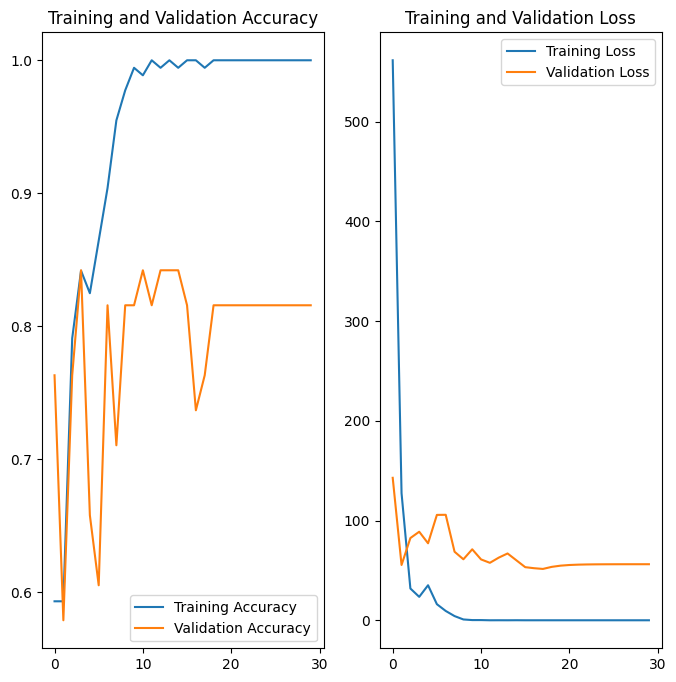

In [110]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [111]:
pred_prob = model.predict(X_test)
y_pred = np.where(pred_prob > 0.5, 1, 0)

2/2 [==============================] - 0s 19ms/step


Overall Accuracy: 0.8947368421052632
Precision: 0.9166666666666666
Recall: 0.9166666666666666
F1-Score: 0.9166666666666666


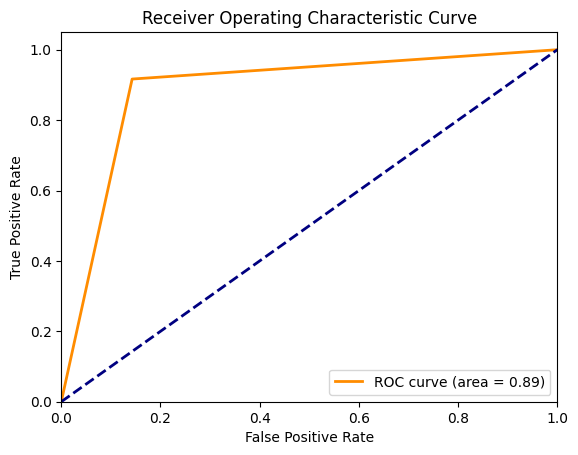

In [112]:
# Compute overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Overall Accuracy:", accuracy)

# Compute precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Compute recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Compute F1-score
f1 = f1_score(y_test, y_pred)
print("F1-Score:", f1)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()
#del model
#del history
#K.clear_session()